In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from common import Fonts, Colors, add_twitter_handle, add_source

In [7]:
df = pd.read_csv("data/matches_2023.csv")
df.head()

,match_number,date,stage,home,away,attendance,home_score,away_score,home_penalty_score,away_penalty_score,...,temperature,wind,group,stadium,winner,match_id,result_id,competition_id,stage_id,season_id
0,1,2023-07-20T19:00:00Z,First Stage,NZL,NOR,42137.0,1.0,0.0,0.0,0.0,...,14.0,26.0,A,Eden Park,NZL,400222852,131872,103,285033,285026
1,2,2023-07-20T20:00:00Z,First Stage,AUS,IRL,75784.0,1.0,0.0,0.0,0.0,...,13.0,10.0,B,Stadium Australia,AUS,400222851,131878,103,285033,285026
2,4,2023-07-21T12:30:00Z,First Stage,NGA,CAN,21410.0,0.0,0.0,0.0,0.0,...,12.0,13.0,B,Melbourne Rectangular Stadium,NaN,400222848,131879,103,285033,285026
3,3,2023-07-21T17:00:00Z,First Stage,PHI,SUI,13711.0,0.0,2.0,0.0,0.0,...,8.0,36.0,A,Dunedin Stadium,SUI,400222854,131873,103,285033,285026
4,5,2023-07-21T19:30:00Z,First Stage,ESP,CRC,22966.0,3.0,0.0,0.0,0.0,...,10.0,37.0,C,Wellington Regional Stadium,ESP,400222844,131884,103,285033,285026


In [8]:
def calculate_points(team, opp):
    if team > opp:
        return 3
    elif team < opp:
        return 0
    else:
        return 1

def get_head_to_head(df, team1, team2):
    for i, row in df.iterrows():
        if row["home"] == team1 and row["away"] == team2:
            if row["home_score"] > row["away_score"]:
                return team1
            elif row["home_score"] < row["away_score"]:
                return team2
            else:
                return None
        elif row["home"] == team2 and row["away"] == team1:
            if row["home_score"] > row["away_score"]:
                return team2
            elif row["home_score"] < row["away_score"]:
                return team1
            else:
                return None
    

def calculate_table(df):
    table = pd.DataFrame([], columns=["team", "points", "goals_for", "goals_against"])
    for team in df["home"].unique():
        points = 0
        goals_for = 0
        goals_against = 0
        for i, match in df.iterrows():
            if match["home"] == team:
                points = points + calculate_points(
                    match["home_score"], match["away_score"]
                )
                goals_for = goals_for + match["home_score"]
                goals_against = goals_against + match["away_score"]
            elif match["away"] == team:
                points = points + calculate_points(
                    match["away_score"], match["home_score"]
                )
                goals_for = goals_for + match["away_score"]
                goals_against = goals_against + match["home_score"]
        table.loc[len(table.index)] = [team, points, int(goals_for), int(goals_against)]

    # Sort table
    table["goal_diff"] = table["goals_for"] - table["goals_against"]
    cols = ["points", "goal_diff", "goals_for"]
    table = table.sort_values(cols, ascending=False).reset_index(drop=True)
    
    # Calculate ties
    first = list(table.loc[0, cols].values)
    second = list(table.loc[1, cols].values)
    third = list(table.loc[2, cols].values)
    fourth = list(table.loc[3, cols].values)
    team1 = table.loc[0, "team"]
    team2 = table.loc[1, "team"]
    team3 = table.loc[2, "team"]
    team4 = table.loc[3, "team"]
    if first == second and first != third:
        h2h = get_head_to_head(df, team1,  team2)
        if h2h == None:
            return (team1 + "*", team2 + "*")
        elif h2h == team1:
            return (team1, team2)
        else:
            return (team2, team1)
    elif first == second and first == third:
        return (team1 + "*", team2 + "*", team3 + "*")
        #raise Exception("1st, 2nd, and 3rd are tied")
    elif second == third and second != fourth:
        h2h = get_head_to_head(df, team2,  team3)
        if h2h == None:
            return (team1, team2 + "*", team3 + "*")
        elif h2h == team2:
            return (team1, team2)
        else:
            return (team1, team3)
    elif second == third and second == fourth:
        return (team1, team2 + "*", team3 + "*", team4 + "*")
        #raise Exception("2nd, 3rd, and 4th are tied")
    return (table.iloc[0]["team"], table.iloc[1]["team"])

In [9]:
def calculate_possibilities(df, group):
    df_group = df[df["group"] == group]
    vals = list(
        map(lambda x: (4 - x if x < 4 else 0, x - 4 if x > 4 else 0), range(0, 9))
    )
    df_poss = pd.DataFrame([], vals, columns=vals)
    for i, i_vals in enumerate(vals):
        for j, j_vals in enumerate(vals):
            df_group.loc[df_group.index[-1], "home_score"] = i_vals[0]
            df_group.loc[df_group.index[-1], "away_score"] = i_vals[1]
            df_group.loc[df_group.index[-2], "home_score"] = j_vals[0]
            df_group.loc[df_group.index[-2], "away_score"] = j_vals[1]
            df_poss.iloc[i, j] = calculate_table(df_group)

    col_ix = pd.MultiIndex.from_product(
        [
            [
                (
                    df_group.loc[df_group.index[-2], "home"],
                    df_group.loc[df_group.index[-2], "away"],
                )
            ],
            df_poss.columns,
        ]
    )
    row_ix = pd.MultiIndex.from_product(
        [
            [
                (
                    df_group.loc[df_group.index[-1], "home"],
                    df_group.loc[df_group.index[-1], "away"],
                )
            ],
            df_poss.index,
        ]
    )
    df_poss = df_poss.set_index(row_ix)
    df_poss.columns = col_ix
    return df_poss


calculate_possibilities(df, "A")

/home/agale/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(NOR, PHI)                                             \
                       (4, 0)      (3, 0)             (2, 0)      (1, 0)   
(SUI, NZL) (4, 0)  (SUI, NOR)  (SUI, NOR)         (SUI, NOR)  (SUI, NOR)   
           (3, 0)  (SUI, NOR)  (SUI, NOR)         (SUI, NOR)  (SUI, NOR)   
           (2, 0)  (SUI, NOR)  (SUI, NOR)         (SUI, NOR)  (SUI, NOR)   
           (1, 0)  (SUI, NOR)  (SUI, NOR)         (SUI, NOR)  (SUI, NOR)   
           (0, 0)  (SUI, NOR)  (SUI, NOR)         (SUI, NOR)  (SUI, NZL)   
           (0, 1)  (NZL, NOR)  (NZL, NOR)  (NZL, SUI*, NOR*)  (NZL, SUI)   
           (0, 2)  (NZL, NOR)  (NZL, NOR)         (NZL, NOR)  (NZL, SUI)   
           (0, 3)  (NZL, NOR)  (NZL, NOR)         (NZL, NOR)  (NZL, NOR)   
           (0, 4)  (NZL, NOR)  (NZL, NOR)         (NZL, NOR)  (NZL, NOR)   

                                                                               
                       (0, 0)      (0, 1)      (0, 2)      (0, 3)      (0, 4)  
(SUI, NZL) (4, 0)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  
           (3, 0)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  
           (2, 0)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  
           (1, 0)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  (SUI, PHI)  
           (0, 0)  (SUI, NZL)  (PHI, SUI)  (PHI, SUI)  (PHI, SUI)  (PHI, SUI)  
           (0, 1)  (NZL, SUI)  (NZL, PHI)  (PHI, NZL)  (PHI, NZL)  (PHI, NZL)  
           (0, 2)  (NZL, SUI)  (NZL, PHI)  (NZL, PHI)  (PHI, NZL)  (PHI, NZL)  
           (0, 3)  (NZL, SUI)  (NZL, PHI)  (NZL, PHI)  (NZL, PHI)  (PHI, NZL)  
           (0, 4)  (NZL, PHI)  (NZL, PHI)  (NZL, PHI)  (NZL, PHI)  (NZL, PHI)

<Figure size 4800x3200 with 0 Axes>

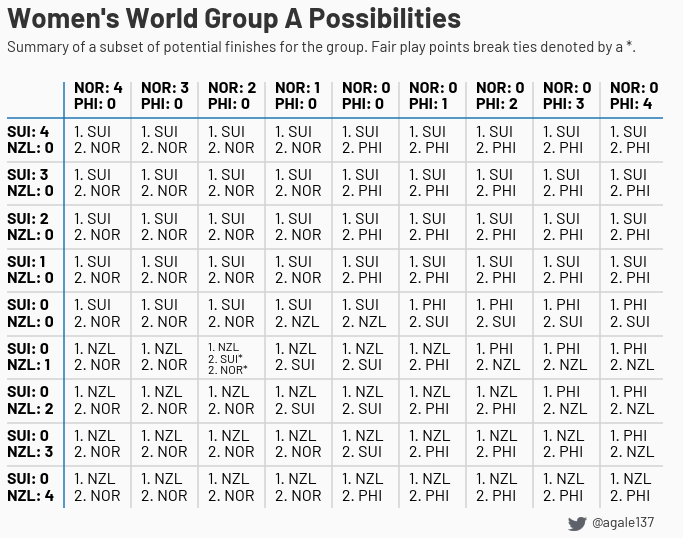

In [11]:
def plot_possibilities(group):

    # Setup
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.figure(dpi=400)
    fig, ax = plt.subplots()
    fig.patch.set_facecolor(Colors.WHITE)
    ax.set_facecolor(Colors.WHITE)

    data = calculate_possibilities(df, group)

    def format_cell(value):
        if len(value) == 4:
            return "1. " + value[0] + "\n2. " + value[1] + "\n2. " + value[2] + "\n2. " + value[3]
        elif "*" not in value[0] and "*" not in value[1]:
            return "1. " + value[0] + "\n2. " + value[1]
        elif "*" in value[0] and len(value) == 2:
            return "1. " + value[0] + "\n1. " + value[1]
        elif "*" in value[0]:
            return "1. " + value[0] + "\n1. " + value[1] + "\n1. " + value[2]
        else:
            return "1. " + value[0] + "\n2. " + value[1] + "\n2. " + value[2]

    # Plot cells
    for x, col in enumerate(data.columns):
        for y, row in enumerate(data.index):
            text =  format_cell(data.iloc[y].iloc[x])
            ax.text(
                x,
                y,
               text,
                fontproperties=Fonts.BARLOW,
                fontsize=16 if len(text) < 16 else 12 if len(text) < 24 else 8,
                va="top",
            )

    # Plot headers
    for x, col in enumerate(data.columns):
        t1, t2 = col[0]
        s1, s2 = col[1]
        ax.text(
            x,
            -1,
            t1 + ": " + str(s1) + "\n" + t2 + ": " + str(s2),
            fontproperties=Fonts.BARLOW_BOLD,
            fontsize=16,
            va="top",
        )
    for y, row in enumerate(data.index):
        t1, t2 = row[0]
        s1, s2 = row[1]
        ax.text(
            -1,
            y,
            t1 + ": " + str(s1) + "\n" + t2 + ": " + str(s2),
            fontproperties=Fonts.BARLOW_BOLD,
            fontsize=16,
            va="top",
        )

    for x in range(1, 9):
        plt.vlines(x=x - 0.15, ymin=-1, ymax=8.8, colors=Colors.LIGHT_GRAY)
    for y in range(1, 9):
        plt.hlines(y=y - 0.15, xmin=-1, xmax=8.8, colors=Colors.LIGHT_GRAY)

    plt.vlines(x=-0.15, ymin=-1, ymax=8.8)
    plt.hlines(y=-0.15, xmin=-1, xmax=8.8)

    ax.set_xlim([-1, len(data.columns)])
    ax.set_ylim([len(data.index), -1])
    ax.axis("off")

    # Title
    ax.set_title(
        "Women's World Group " + group + " Possibilities",
        fontproperties=Fonts.BARLOW_BOLD,
        color=Colors.BLACK,
        size=28,
        ha="left",
        x=0,
        y=1.11,
    )

    # Subtitle
    ax.text(
        -1,
        -1.7,
        "Summary of a subset of potential finishes for the group. Fair play points break ties denoted by a *.",
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
        size=15,
        ha="left",
    )

    # Twitter logo and username
    add_twitter_handle(fig, x=0.77, y=0.1, fs=14, w=0.025)

    # Save image
    plt.savefig(
        "images/group_" + group + "_table.png",
        bbox_inches="tight",
        transparent=False,
        pad_inches=0.5,
        dpi=200,
    )


plot_possibilities("A")

<Figure size 4800x3200 with 0 Axes>

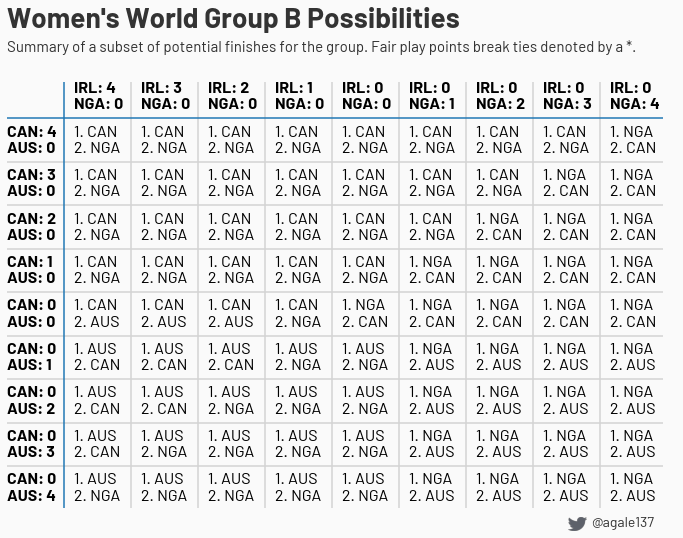

In [162]:
plot_possibilities("B")

<Figure size 4800x3200 with 0 Axes>

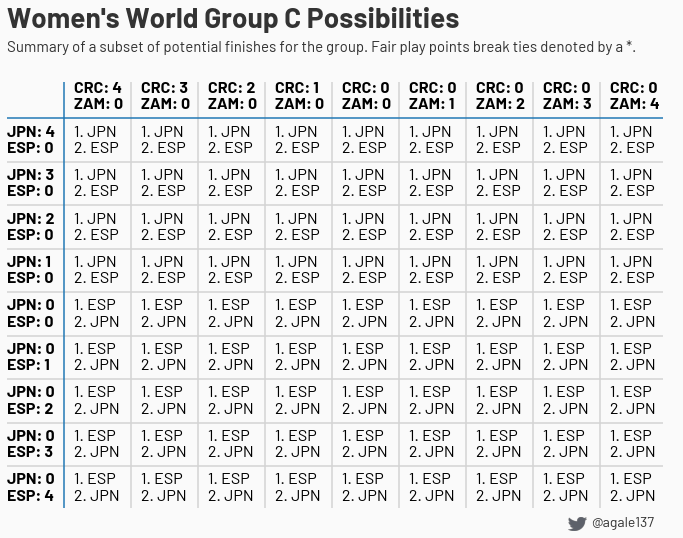

In [163]:
plot_possibilities("C")

<Figure size 4800x3200 with 0 Axes>

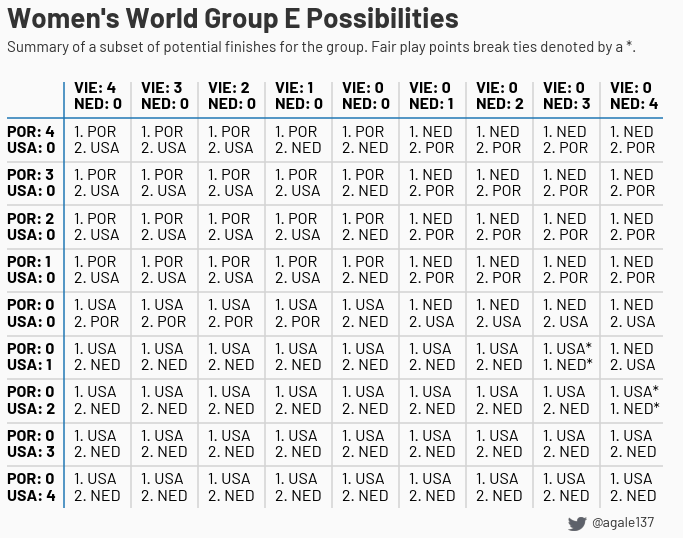

In [164]:
plot_possibilities("E")

<Figure size 4800x3200 with 0 Axes>

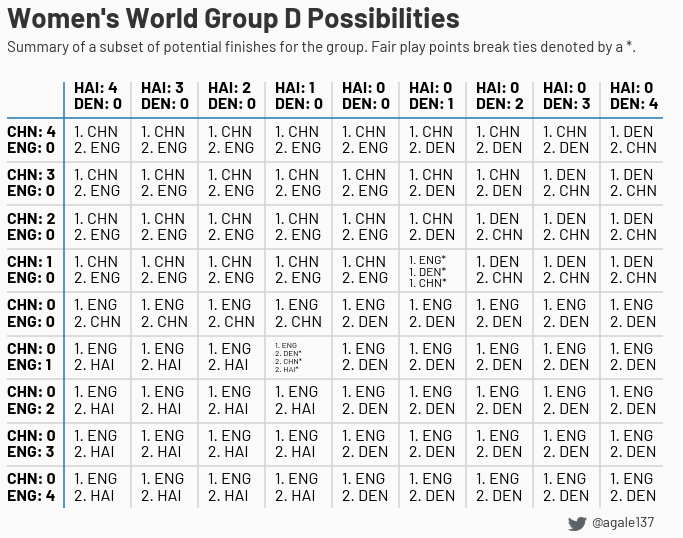

In [24]:
plot_possibilities("D")

<Figure size 4800x3200 with 0 Axes>

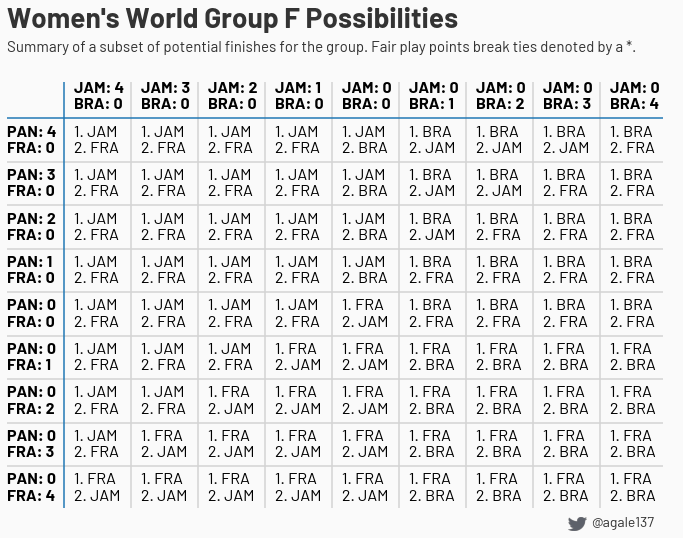

In [6]:
plot_possibilities("F")

<Figure size 4800x3200 with 0 Axes>

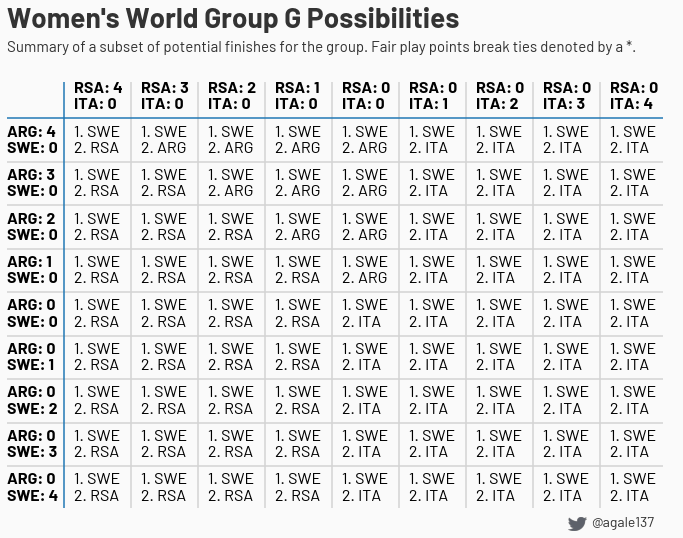

In [7]:
plot_possibilities("G")

<Figure size 4800x3200 with 0 Axes>

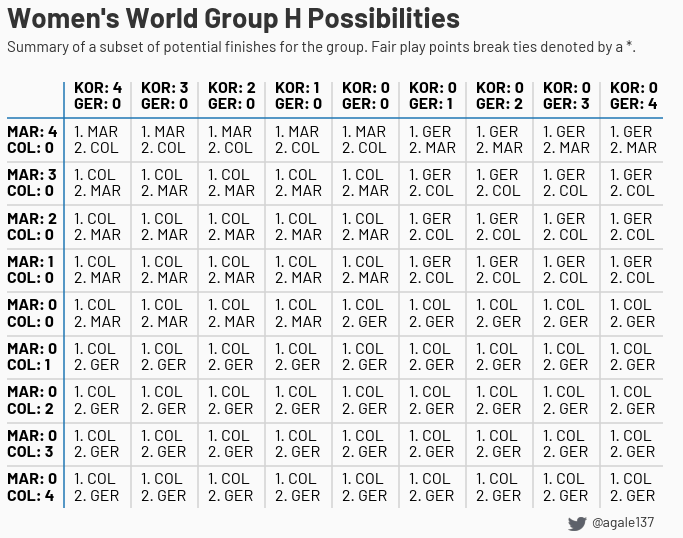

In [12]:
plot_possibilities("H")